# PatchSim

In [1]:
# Importando librerías
import pandas as pd
import patchsim as sim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#-----------------------------------------------------------------------------------------
# Parámetros
alpha = 1/7    # Tasa de infección (tiempo promedio de incubación)
gamma = 1/4.8  # Tasa de recuperación (periodo infeccioso medio)
beta = 0.4     # Tasa de expuestos: prob. que susceptible se infecte.
T = 400        # Simulación de dias
print("beta=%.3f - alpha=%.3f - gamma=%.3f"%(beta, alpha, gamma))

beta=0.400 - alpha=0.143 - gamma=0.208


# Configuraciones
cfg.txt: Archivo de configuraciones

In [3]:
f = open("files/cfg.txt", "w")
f.write("""
PatchFile=files/pop.txt
NetworkFile=files/net.txt
NetworkType=Weekly
SeedFile=files/seeds.txt

ExposureRate=0.4
InfectionRate=0.143
RecoveryRate=0.208
ScalingFactor=0.086

StartDate=1
Duration=400

LoadState=False
SaveState=False

OutputFile=resultados.out
OutputFormat=Whole
LogFile=proceso.log
""")
f.close()

# Poblaciones

In [4]:
# pop.txt: Archivo que contiene las poblaciones
#-----------------------------------------------------------------------------------------
localidades = pd.read_csv("files/info_local_2020.csv")
df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                        "poblacion":localidades["PopCDR"].values})
df.to_csv("files/pop.txt", header = False, index = False, sep=' ')
#-----------------------------------------------------------------------------------------
N=df["poblacion"].sum()  # Cantidad de personas
print("Total poblacion =",N) 
df.T

Total poblacion = 5549758


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id_localidades,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
poblacion,369936,152168,93928,257646,230318,124375,458427,730237,272242,617260,865749,169295,117041,73041,76972,158021,19142,265916,498044


# Conexiones net.txt

**Disminuyendo el 60% en cada semana**

In [5]:
# Conexiones: net.txt - Contiene las conectividades de viajes entre cada poblacion 19x19
#-----------------------------------------------------------------------------------------
redes = pd.read_csv("files/cdr_od_loc.csv")
nxn = len(redes)
#-----------------------------------------------------------------------------------------
# Semana 0
dias = np.zeros(len(redes), dtype=int)
#-----------------------------------------------------------------------------------------
# Normalizamos matriz de conexiones:
hbw = redes["hbw"].values
W = hbw.reshape(-1,19) 
for i in range(19):
    total_i = np.sum(W[i,:]) # Total en localidad i
    W[i,:] = W[i,:]/total_i
W0_norm = W.copy()
hbw=W.reshape(-1)
#-----------------------------------------------------------------------------------------
# Disminuyendo 60% por semana:
for k in range(1,53):  
    W1 = np.zeros((19,19))
    for i in range(19):
        W1[i,:] = W[i,:]*0.60
        W1[i,i] = 0
        W1[i,i] = 1 - W1[i,:].sum()
    W=W1.copy()
    hbw = np.append(hbw, W1.reshape(-1))
    dias= np.append(dias, np.zeros(nxn, dtype=int)+k)
#-----------------------------------------------------------------------------------------
df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*53, 
                    "destino":list(redes["d_loc"].values)*53, 
                    "dia":dias,
                    "hbw":hbw})
df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7,8,9,...,19123,19124,19125,19126,19127,19128,19129,19130,19131,19132
origen,1.0000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,19.0
destino,1.0000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,1.000000e+01,1.100000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.500000e+01,1.600000e+01,1.700000e+01,1.800000e+01,19.0
dia,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,52.0
hbw,0.4647,0.069091,0.00925,0.033299,0.024774,0.007146,0.035622,0.029503,0.013231,0.029674,...,2.180476e-13,1.491675e-13,1.383980e-13,7.137111e-14,2.326747e-14,2.890109e-14,6.805935e-14,5.548481e-15,1.420802e-13,1.0


**Disminuyendo según archivo**

In [6]:
ratio = pd.read_csv("files/agregados_localidad.csv")
ratio.describe()

# Matriz semana x localidad, cada item contiene radio de disminucion
ratios = np.ones((53, 19))
for index, row in ratio.iterrows(): 
    ratios[int(row.week)-1, int(row.loc_id)-1]=row.ratio    

# Matriz de movilidad en semana 0: 19x19
W0 = W0_norm
hbw=W0.reshape(-1)
for k in range(1,53):  
    W1 = np.zeros((19,19))  # Inicializando matriz de movilidad en semana k
    for i in range(19):
        W1[i,:] = W0[i,:]*ratios[k,i]
        W1[i,i] = 0
        W1[i,i] = 1 - W1[i,:].sum()
    W0=W1.copy()
    hbw = np.append(hbw, W1.reshape(-1))

#-----------------------------------------------------------------------------------------
df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*53, 
                    "destino":list(redes["d_loc"].values)*53, 
                    "dia":dias,
                    "hbw":hbw})
df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7,8,9,...,19123,19124,19125,19126,19127,19128,19129,19130,19131,19132
origen,1.0000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,19.0
destino,1.0000,2.000000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,1.000000e+01,1.100000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.500000e+01,1.600000e+01,1.700000e+01,1.800000e+01,19.0
dia,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,52.0
hbw,0.4647,0.069091,0.00925,0.033299,0.024774,0.007146,0.035622,0.029503,0.013231,0.029674,...,6.234213e-12,4.264857e-12,3.956946e-12,2.040576e-12,6.652419e-13,8.263131e-13,1.945889e-12,1.586370e-13,4.062224e-12,1.0


## Semillas seeds.txt

In [7]:
# Semillas: seeds.txt - Contiene los infectados iniciales durante los primeros 7 dias de la pandemia de cada localidad
#---------------------------------------------------------------------------------------------------------------------
Casos = pd.read_csv("files/osb_enftransm-covid-19_17042021.csv", nrows=732872, encoding='latin-1', delimiter=";")
# Renombrando columnas
casos = Casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                              "FECHA_DIAGNOSTICO":'fecha'})
                             #"FECHA_DE_INICIO_DE_SINTOMAS":'fecha'})
                             
#---------------------------------------------------------------------------------------------------------------------
# Convirtiendo en formato fecha de pandas
casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
dia1 = casos["fecha"].min()  # Primer caso de covid en Bogotá  # 6 de marzo de 2020
#---------------------------------------------------------------------------------------------------------------------
# Calculando el tiempo transcurrido en dias
tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
casos['dia'] = tiempo.dt.days
#casos.dropna(subset=['dia'], inplace=True)
#casos.dia = casos['dia'].apply(np.int)
#---------------------------------------------------------------------------------------------------------------------
# Uniendo base de datos localidades y número de casos
datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".
Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='# Casos')  # Cantidad de casos
#---------------------------------------------------------------------------------------------------------------------
# Semillas: Cantidad de infectados en los primeros 7 dias para cada localidad.
df = Ncasos[Ncasos["dia"]<=10]    
df.to_csv("files/seeds.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dia,0,4,6,6,7,7,7,7,8,8,8,8,9,9,9,9,9,9,10,10
local_id,1,10,8,9,2,10,11,13,2,9,11,13,1,2,8,10,12,19,1,11
# Casos,1,2,1,1,1,3,1,1,1,1,1,1,3,6,2,1,2,1,1,1


## Llamando la función PatchSim

In [8]:
# Ejecutando función PatchSim
#---------------------------------------------------------------------------------------------------------------------
configs = sim.read_config('files/cfg.txt')
sim.run_disease_simulation(configs, write_epi=True)

371638

## Gráficos reales vs simulaciones

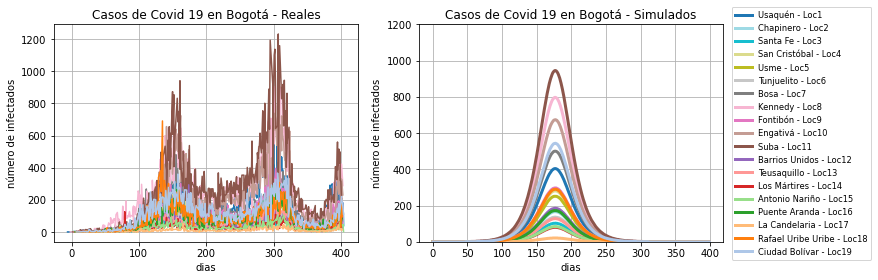

In [9]:
Ncasos["dia"] = Ncasos["dia"].apply(lambda x: x-int(np.random.gamma(5)))
Ncasos.sort_values(by="dia", inplace=True)
#--------------------------------------------------------------------------------------------------------------
infec = np.loadtxt("resultados.out")
infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
infec = infec.sort_index()
#--------------------------------------------------------------------------------------------------------------
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in np.linspace(0, 1, 19)]
c=0
#--------------------------------------------------------------------------------------------------------------
# Graficos
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,4))
for i in localidades["local_id"].values:
    #--------------------------------------------------------------------------------------------------------------
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    casos = loc["# Casos"].values
    tiempo = loc["dia"].values
    ax1.plot(tiempo, casos, label="Reales", color=colors[-c])
    #--------------------------------------------------------------------------------------------------------------
    # Casos simulaciones
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax2.plot(t, infectados, lw=3, label=str(localidades["Localidad"][i-1]) + " - Loc"+str(i), color=colors[-c])
    ax2.legend(loc="right", bbox_to_anchor=(1.5,0.5), fontsize=8.3)
    #--------------------------------------------------------------------------------------------------------------
    # Propiedades gráficas
    ax1.set_title("Casos de Covid 19 en Bogotá - Reales")
    ax2.set_title("Casos de Covid 19 en Bogotá - Simulados")
    ax1.set_xlabel("dias")
    ax2.set_xlabel("dias")
    ax1.set_ylabel("número de infectados")
    ax2.set_ylabel("número de infectados")
    ax1.grid()
    ax2.grid()
    ax2.set_ylim([0,1200])
    c+=1

## Gráficos reales vs simulaciones individules

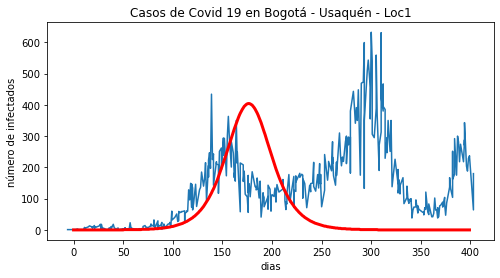

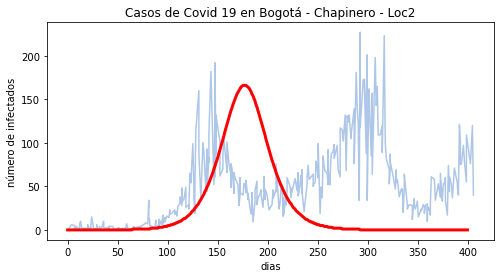

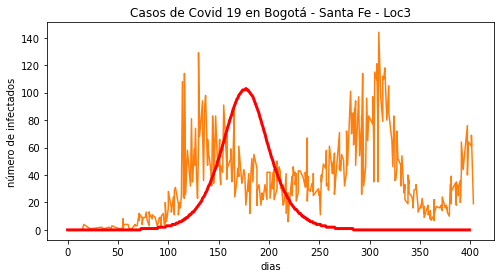

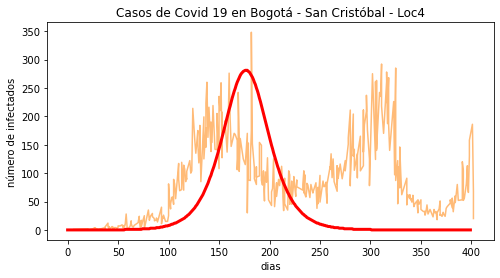

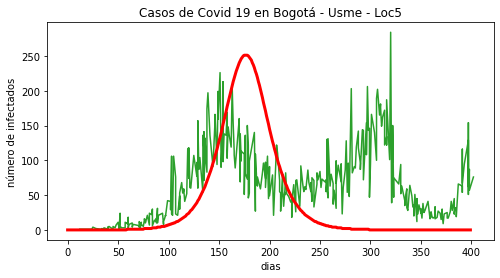

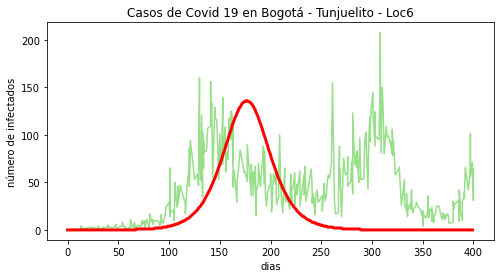

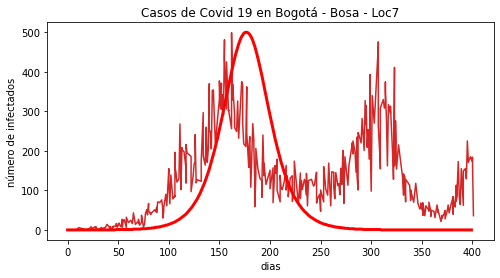

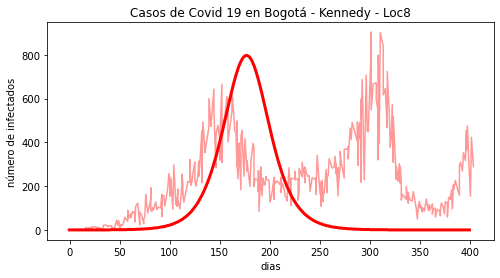

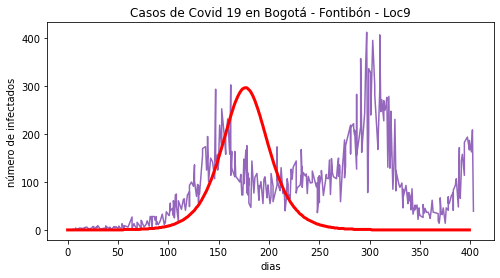

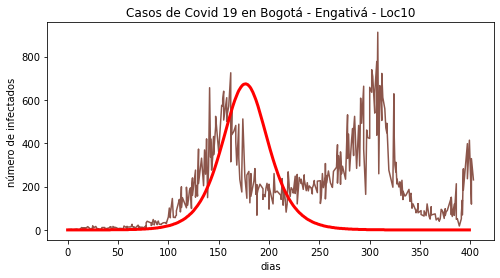

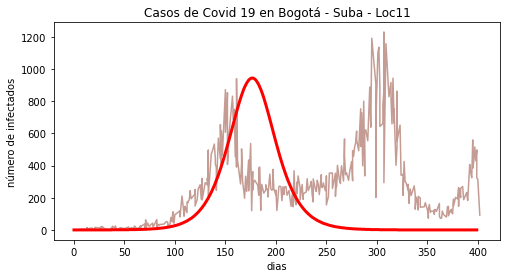

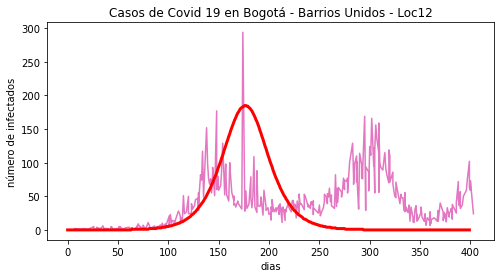

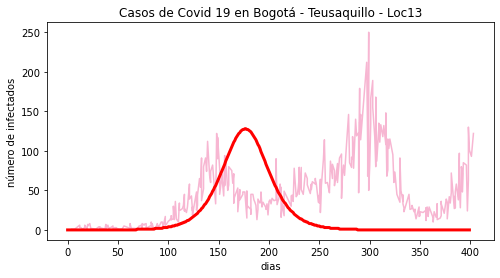

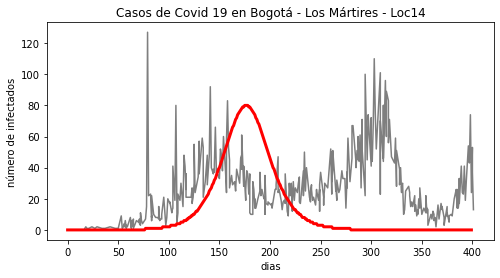

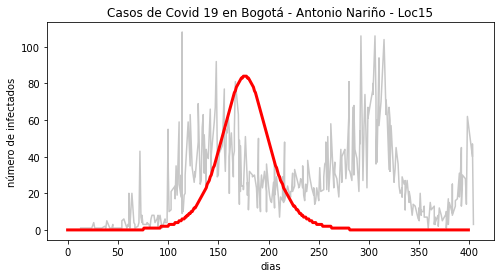

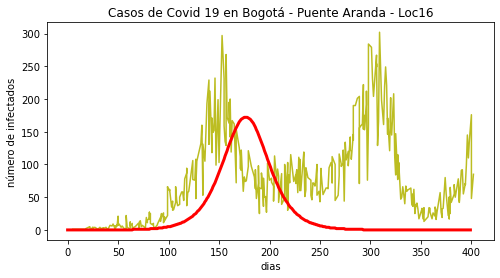

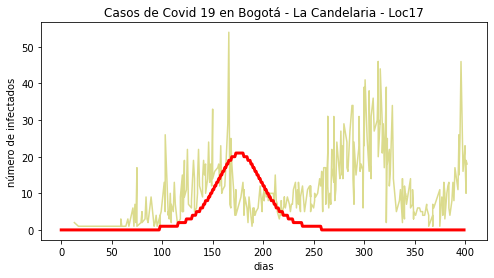

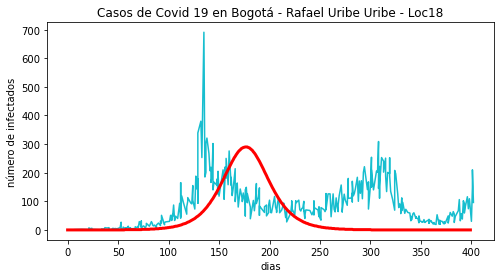

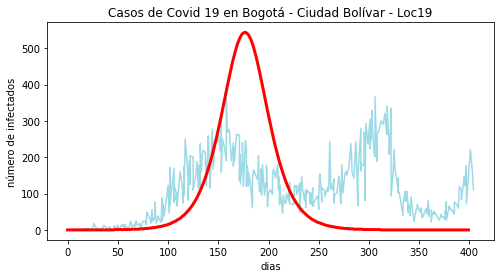

In [10]:
# Graficos
c=0
for i in localidades["local_id"].values:
    fig, ax1 = plt.subplots(figsize=(8,4))
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    tiempo = loc["dia"].values
    casos = loc["# Casos"].values
    ax1.plot(tiempo, casos, label="Reales", color=colors[c])
    # Casos simulaciones
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax1.plot(t, infectados, label="Simulaciones", lw=3, color="red")
    # Propiedades gráficas
    ax1.set_xlabel("dias")
    ax1.set_title("Casos de Covid 19 en Bogotá - "+str(localidades["Localidad"][i-1]) + " - Loc"+str(i))
    ax1.set_ylabel("número de infectados")
    c+=1

## Referencias

+ Análisis del Covid-19 por medio de un modelo SEIR  
    https://institucional.us.es/blogimus/2020/03/covid-19-analisis-por-medio-de-un-modelo-seir/
      
+ Modelo SEIR para Colombia: Medidas de mitigación del virus  
    https://www.eafit.edu.co/escuelas/economiayfinanzas/cief/Documents/informe-especial-2020-abril-2.pdf
      
+ shinySIR: Interactive plotting for infectious disease models  
    https://cran.r-project.org/web/packages/shinySIR/vignettes/Vignette.html